In [1]:
import sys
sys.path.append('../code')
from synthetic_funcs import *
import torch as t 
import torch.nn.functional as F
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [2]:
run_num = 10 
epoch_num = 20000
exp_ver = '3'

start_lambda1 = 0.5
start_temp  = 1.0

# Data preparation

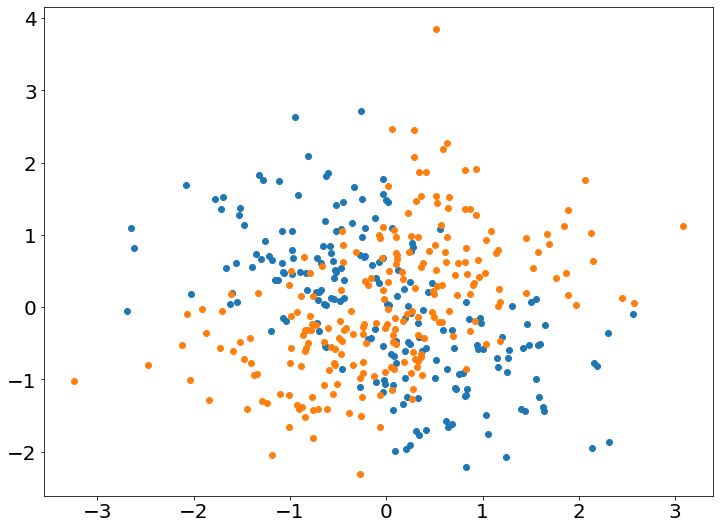

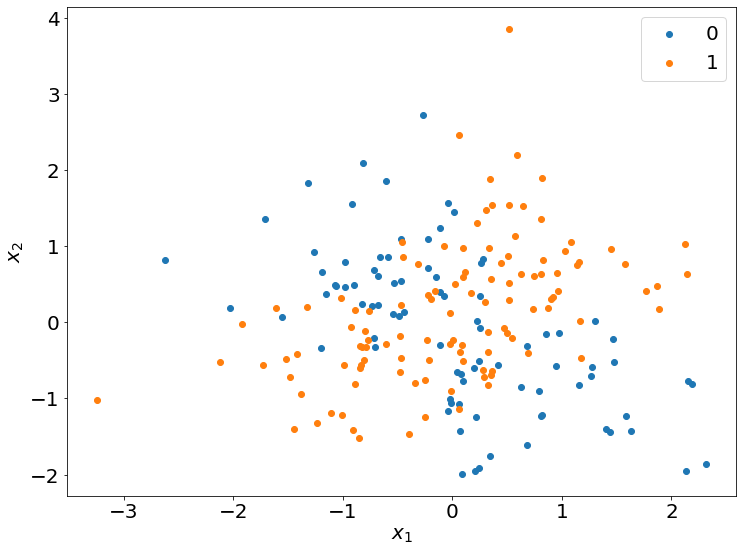

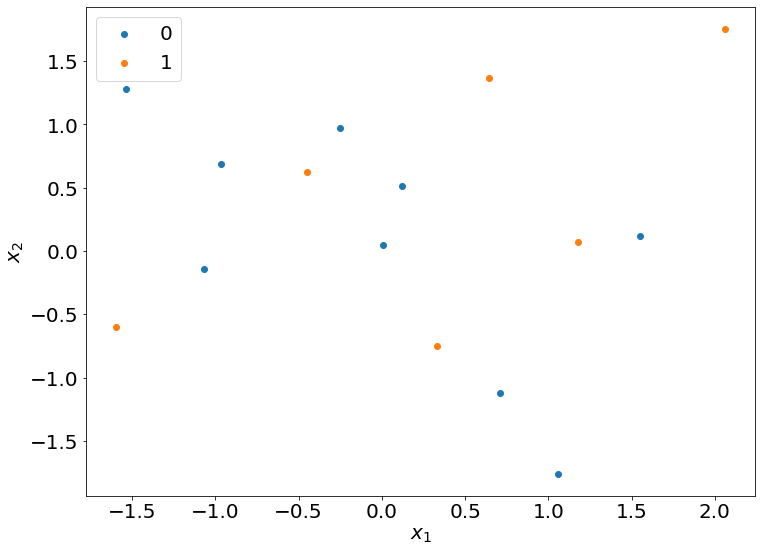

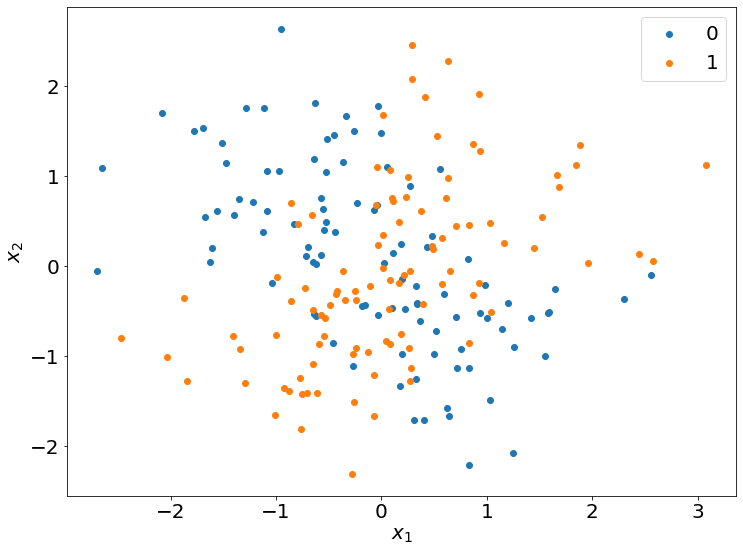

In [3]:
np.random.seed(42)
teacher_train_size, student_train_size, student_validation_size, test_size = 200, 15, 15, 200
total_size =  sum([teacher_train_size, student_train_size, student_validation_size, test_size])
eps = .5
"""
Y генерируется как:
    sign (x1 * x2) + шум
    
Признаки для учителя:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак коррелирует с Y, но не покрывает его
    
Признаки для ученика:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак отличается от Y из-за шума
        
    
"""
# полные данные
x_big = np.random.randn(total_size, 2)
y_big = (np.sign(x_big[:,0]*x_big[:,1]+np.random.randn(total_size)*eps)+1)//2
x_big = np.vstack([x_big[:,0], x_big[:,1],  (np.sign(x_big[:,0])+np.sign(x_big[:,1]) >0.1)*1.0, 
                   x_big[:,0]*x_big[:,1]]).T

# обучение учителя. NB: не пересекается с выборкой для обучения ученика, так проще подобрать параметры
x_ttrain = t.tensor(x_big[:teacher_train_size], dtype=t.float32)
y_ttrain = t.tensor(y_big[:teacher_train_size], dtype=t.long)


# обучение ученика
x_train = t.tensor(x_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.float32)
y_train = t.tensor(y_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.long)

# валидация, в этом ноутбуке не используется
x_val = t.tensor(x_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], 
                 dtype=t.float32)
y_val = t.tensor(y_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], dtype=t.long)


x_test = t.tensor(x_big[-test_size:], dtype=t.float32)
y_test = t.tensor(y_big[-test_size:], dtype=t.long)

plt.scatter(x_big[y_big==0,0], x_big[y_big==0,1])
plt.scatter(x_big[y_big==1,0], x_big[y_big==1,1])

plt.show()

plt.scatter(x_ttrain[y_ttrain==0,0], x_ttrain[y_ttrain==0,1], label='0')
plt.scatter(x_ttrain[y_ttrain==1,0], x_ttrain[y_ttrain==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('../figs/ttrain.pdf')
plt.legend()
plt.show()

plt.scatter(x_train[y_train==0,0], x_train[y_train==0,1], label='0')
plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('../figs/train.pdf')
plt.legend()
plt.show()

plt.scatter(x_test[y_test==0,0], x_test[y_test==0,1], label='0')
plt.scatter(x_test[y_test==1,0], x_test[y_test==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('../figs/test.pdf')
plt.legend()
plt.show()


# Experiments

### teacher training

In [12]:
# обучение учителя

teacher=net_training(epoch_num, x_net_train=x_ttrain, y_net_train=y_ttrain, x_net_test=x_test,
             y_net_test=y_test, order=[0,1,2], lr0=1e-2)

0.575
0.615
0.66
0.665
0.665
0.67
0.665
0.675
0.675
0.685
0.685
0.69
0.69
0.69
0.685
0.69
0.69
0.69
0.69
0.69


### without distillation

In [13]:
# обучение студента без дистилляции

start_lambda1=1.0
start_temp=1.0

filename=None
synthetic_base(exp_ver, 1, epoch_num, start_lambda1, start_temp, filename, order=[0,1,3], 
               teacher=teacher, x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, lr0=1e-2)

0.61
0.74
0.74
0.755
0.76
0.76
0.76
0.76
0.755
0.755
0.755
0.755
0.755
0.755
0.755
0.755
0.755
0.755
0.755
0.755


### full distillation

In [14]:
# полная дистилляция

start_lambda1 = 0.0
start_temp = 1.0

filename=None
synthetic_base(exp_ver, 1, epoch_num, start_lambda1, start_temp, filename, order=[0,1,3], 
               teacher=teacher, x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, lr0=1e-2)

0.605
0.585
0.6
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605


### distillation with different coefficients

In [15]:
# дистилляция с разными коэффициентами

start_lambda1 = .5
start_temp = 1.0

filename=None
synthetic_base(exp_ver, 1, epoch_num, start_lambda1, start_temp, filename, order=[0,1,3], 
               teacher=teacher, x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, lr0=1e-2)

0.605
0.765
0.785
0.785
0.79
0.795
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


### distillation with random meta-parameters

In [16]:
# дистилляция со случайными гиперпараметрами
# NB: здесь оставляем такую же инициализацию параметров, что и раньше! 
# это так задумано

filename='random'
synthetic_base(exp_ver, run_num, epoch_num, start_lambda1, start_temp, filename, order=[0,1,3], teacher=teacher,
               x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, mode='random', lr0=0.01)

{'epoch': 0, 'accuracy': 0.6050000190734863, 'temp': 9.51207160949707, 'lambda1': 0.3745401203632355}
{'epoch': 1000, 'accuracy': 0.7599999904632568, 'temp': 9.51207160949707, 'lambda1': 0.3745401203632355}
{'epoch': 2000, 'accuracy': 0.7400000095367432, 'temp': 9.51207160949707, 'lambda1': 0.3745401203632355}
{'epoch': 3000, 'accuracy': 0.7400000095367432, 'temp': 9.51207160949707, 'lambda1': 0.3745401203632355}
{'epoch': 4000, 'accuracy': 0.7400000095367432, 'temp': 9.51207160949707, 'lambda1': 0.3745401203632355}
{'epoch': 5000, 'accuracy': 0.7450000047683716, 'temp': 9.51207160949707, 'lambda1': 0.3745401203632355}
{'epoch': 6000, 'accuracy': 0.7400000095367432, 'temp': 9.51207160949707, 'lambda1': 0.3745401203632355}
{'epoch': 7000, 'accuracy': 0.7400000095367432, 'temp': 9.51207160949707, 'lambda1': 0.3745401203632355}
{'epoch': 8000, 'accuracy': 0.7450000047683716, 'temp': 9.51207160949707, 'lambda1': 0.3745401203632355}
{'epoch': 9000, 'accuracy': 0.75, 'temp': 9.51207160949707

{'epoch': 18000, 'accuracy': 0.75, 'temp': 8.67514419555664, 'lambda1': 0.058083612471818924}
{'epoch': 19000, 'accuracy': 0.75, 'temp': 8.67514419555664, 'lambda1': 0.058083612471818924}
{'epoch': 0, 'accuracy': 0.675000011920929, 'temp': 7.109918594360352, 'lambda1': 0.6011149883270264}
{'epoch': 1000, 'accuracy': 0.7200000286102295, 'temp': 7.109918594360352, 'lambda1': 0.6011149883270264}
{'epoch': 2000, 'accuracy': 0.7350000143051147, 'temp': 7.109918594360352, 'lambda1': 0.6011149883270264}
{'epoch': 3000, 'accuracy': 0.7400000095367432, 'temp': 7.109918594360352, 'lambda1': 0.6011149883270264}
{'epoch': 4000, 'accuracy': 0.7450000047683716, 'temp': 7.109918594360352, 'lambda1': 0.6011149883270264}
{'epoch': 5000, 'accuracy': 0.75, 'temp': 7.109918594360352, 'lambda1': 0.6011149883270264}
{'epoch': 6000, 'accuracy': 0.7549999952316284, 'temp': 7.109918594360352, 'lambda1': 0.6011149883270264}
{'epoch': 7000, 'accuracy': 0.7549999952316284, 'temp': 7.109918594360352, 'lambda1': 0.

{'epoch': 16000, 'accuracy': 0.7200000286102295, 'temp': 1.915704607963562, 'lambda1': 0.1818249672651291}
{'epoch': 17000, 'accuracy': 0.7200000286102295, 'temp': 1.915704607963562, 'lambda1': 0.1818249672651291}
{'epoch': 18000, 'accuracy': 0.7200000286102295, 'temp': 1.915704607963562, 'lambda1': 0.1818249672651291}
{'epoch': 19000, 'accuracy': 0.7200000286102295, 'temp': 1.915704607963562, 'lambda1': 0.1818249672651291}
{'epoch': 0, 'accuracy': 0.2750000059604645, 'temp': 5.295088768005371, 'lambda1': 0.30424225330352783}
{'epoch': 1000, 'accuracy': 0.6700000166893005, 'temp': 5.295088768005371, 'lambda1': 0.30424225330352783}
{'epoch': 2000, 'accuracy': 0.6899999976158142, 'temp': 5.295088768005371, 'lambda1': 0.30424225330352783}
{'epoch': 3000, 'accuracy': 0.7200000286102295, 'temp': 5.295088768005371, 'lambda1': 0.30424225330352783}
{'epoch': 4000, 'accuracy': 0.7350000143051147, 'temp': 5.295088768005371, 'lambda1': 0.30424225330352783}
{'epoch': 5000, 'accuracy': 0.7400000095

### with meta-parameter optimization

In [17]:
# дистилляция с оптимизацией гиперапарметров

filename='opt'
synthetic_opt(exp_ver, run_num, epoch_num, filename, teacher=teacher, 
              x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, 
              alg_pars=[(10, 2)], lr0=1e-2, mode='opt')

{'epoch': 0, 'accuracy': 0.6050000190734863, 'temp': 9.51207160949707, 'lambda1': 0.3724561631679535}
{'epoch': 1000, 'accuracy': 0.7400000095367432, 'temp': 9.51207160949707, 'lambda1': 0.10167721658945084}
{'epoch': 2000, 'accuracy': 0.7400000095367432, 'temp': 9.51207160949707, 'lambda1': 0.08337864279747009}
{'epoch': 3000, 'accuracy': 0.75, 'temp': 9.51207160949707, 'lambda1': 0.0750603973865509}
{'epoch': 4000, 'accuracy': 0.7549999952316284, 'temp': 9.51207160949707, 'lambda1': 0.07077217102050781}
{'epoch': 5000, 'accuracy': 0.7599999904632568, 'temp': 9.51207160949707, 'lambda1': 0.06825587898492813}
{'epoch': 6000, 'accuracy': 0.7599999904632568, 'temp': 9.51207160949707, 'lambda1': 0.06661483645439148}
{'epoch': 7000, 'accuracy': 0.7599999904632568, 'temp': 9.51207160949707, 'lambda1': 0.06544612348079681}
{'epoch': 8000, 'accuracy': 0.7599999904632568, 'temp': 9.51207160949707, 'lambda1': 0.06454842537641525}
{'epoch': 9000, 'accuracy': 0.7549999952316284, 'temp': 9.5120716

{'epoch': 0, 'accuracy': 0.675000011920929, 'temp': 7.109918594360352, 'lambda1': 0.600731611251831}
{'epoch': 1000, 'accuracy': 0.7149999737739563, 'temp': 7.109918594360352, 'lambda1': 0.4527369439601898}
{'epoch': 2000, 'accuracy': 0.7300000190734863, 'temp': 7.109918594360352, 'lambda1': 0.4104010760784149}
{'epoch': 3000, 'accuracy': 0.7400000095367432, 'temp': 7.109918594360352, 'lambda1': 0.39030399918556213}
{'epoch': 4000, 'accuracy': 0.7400000095367432, 'temp': 7.109918594360352, 'lambda1': 0.37913763523101807}
{'epoch': 5000, 'accuracy': 0.7450000047683716, 'temp': 7.109918594360352, 'lambda1': 0.37219998240470886}
{'epoch': 6000, 'accuracy': 0.75, 'temp': 7.109918594360352, 'lambda1': 0.36749598383903503}
{'epoch': 7000, 'accuracy': 0.7549999952316284, 'temp': 7.109918594360352, 'lambda1': 0.36407262086868286}
{'epoch': 8000, 'accuracy': 0.7599999904632568, 'temp': 7.109918594360352, 'lambda1': 0.36142805218696594}
{'epoch': 9000, 'accuracy': 0.7599999904632568, 'temp': 7.1

{'epoch': 0, 'accuracy': 0.2800000011920929, 'temp': 5.295070171356201, 'lambda1': 0.29934006929397583}
{'epoch': 1000, 'accuracy': 0.7149999737739563, 'temp': 5.294524669647217, 'lambda1': -0.0}
{'epoch': 2000, 'accuracy': 0.7400000095367432, 'temp': 5.294524669647217, 'lambda1': -0.0}
{'epoch': 3000, 'accuracy': 0.75, 'temp': 5.294524669647217, 'lambda1': -0.0}
{'epoch': 4000, 'accuracy': 0.7549999952316284, 'temp': 5.294524669647217, 'lambda1': 0.00028748883050866425}
{'epoch': 5000, 'accuracy': 0.7599999904632568, 'temp': 5.294524669647217, 'lambda1': 0.0023106192238628864}
{'epoch': 6000, 'accuracy': 0.7599999904632568, 'temp': 5.294524669647217, 'lambda1': 0.005440223030745983}
{'epoch': 7000, 'accuracy': 0.7599999904632568, 'temp': 5.294524669647217, 'lambda1': 0.009164206683635712}
{'epoch': 8000, 'accuracy': 0.7599999904632568, 'temp': 5.294524669647217, 'lambda1': 0.013222207315266132}
{'epoch': 9000, 'accuracy': 0.7549999952316284, 'temp': 5.294524669647217, 'lambda1': 0.017

### distillation with linear models (par: epoch_size)

In [18]:
# дистилляция со сплайнами
# параметр: сколько итераций длится одна эпоха. Обучаемся каждую вторую эпоху

filename='splines'
synthetic_opt(exp_ver, run_num, epoch_num, filename, teacher, x_train, 
              y_train, x_test, y_test, 
              alg_pars=[(10, 2), (100, 2), (1000, 2), (2000, 2)], 
              lr0 = 10.0, lr = 0.01, mode='splines')

{'epoch': 0, 'accuracy': 0.6549999713897705, 'temp': 9.512070655822754, 'lambda1': 0.3746401071548462}
{'epoch': 1000, 'accuracy': 0.6800000071525574, 'temp': 9.514120101928711, 'lambda1': 0.4005102813243866}
{'epoch': 2000, 'accuracy': 0.6800000071525574, 'temp': 9.516027450561523, 'lambda1': 0.4008127748966217}
{'epoch': 3000, 'accuracy': 0.6800000071525574, 'temp': 9.517603874206543, 'lambda1': 0.4011152684688568}
{'epoch': 4000, 'accuracy': 0.6800000071525574, 'temp': 9.519034385681152, 'lambda1': 0.4014177620410919}
{'epoch': 5000, 'accuracy': 0.6800000071525574, 'temp': 9.520464897155762, 'lambda1': 0.401720255613327}
{'epoch': 6000, 'accuracy': 0.6800000071525574, 'temp': 9.521895408630371, 'lambda1': 0.40202274918556213}
{'epoch': 7000, 'accuracy': 0.6800000071525574, 'temp': 9.52332592010498, 'lambda1': 0.40232524275779724}
{'epoch': 8000, 'accuracy': 0.6800000071525574, 'temp': 9.52475643157959, 'lambda1': 0.40262773633003235}
{'epoch': 9000, 'accuracy': 0.6800000071525574, '

{'epoch': 18000, 'accuracy': 0.8149999976158142, 'temp': 8.729976654052734, 'lambda1': 0.40363460779190063}
{'epoch': 19000, 'accuracy': 0.8149999976158142, 'temp': 8.73236083984375, 'lambda1': 0.4036230742931366}
{'epoch': 0, 'accuracy': 0.7200000286102295, 'temp': 7.109905242919922, 'lambda1': 0.6010149717330933}
{'epoch': 1000, 'accuracy': 0.75, 'temp': 7.1099772453308105, 'lambda1': 0.5514170527458191}
{'epoch': 2000, 'accuracy': 0.7549999952316284, 'temp': 7.109423637390137, 'lambda1': 0.5136978626251221}
{'epoch': 3000, 'accuracy': 0.7599999904632568, 'temp': 7.1084699630737305, 'lambda1': 0.4831649959087372}
{'epoch': 4000, 'accuracy': 0.7599999904632568, 'temp': 7.107272624969482, 'lambda1': 0.4576317369937897}
{'epoch': 5000, 'accuracy': 0.7599999904632568, 'temp': 7.105842113494873, 'lambda1': 0.4357905983924866}
{'epoch': 6000, 'accuracy': 0.699999988079071, 'temp': 7.105401515960693, 'lambda1': 0.42792224884033203}
{'epoch': 7000, 'accuracy': 0.699999988079071, 'temp': 7.10

{'epoch': 16000, 'accuracy': 0.6449999809265137, 'temp': 2.0486035346984863, 'lambda1': 0.5467048287391663}
{'epoch': 17000, 'accuracy': 0.6449999809265137, 'temp': 2.0483055114746094, 'lambda1': 0.5470088124275208}
{'epoch': 18000, 'accuracy': 0.6449999809265137, 'temp': 2.0480074882507324, 'lambda1': 0.5473127961158752}
{'epoch': 19000, 'accuracy': 0.6449999809265137, 'temp': 2.0477094650268555, 'lambda1': 0.5476167798042297}
{'epoch': 0, 'accuracy': 0.7049999833106995, 'temp': 5.2950968742370605, 'lambda1': 0.30434224009513855}
{'epoch': 1000, 'accuracy': 0.6499999761581421, 'temp': 5.312309741973877, 'lambda1': 0.40302973985671997}
{'epoch': 2000, 'accuracy': 0.675000011920929, 'temp': 5.316364288330078, 'lambda1': 0.4338349997997284}
{'epoch': 3000, 'accuracy': 0.675000011920929, 'temp': 5.318915367126465, 'lambda1': 0.4341374933719635}
{'epoch': 4000, 'accuracy': 0.675000011920929, 'temp': 5.3212571144104, 'lambda1': 0.4344399869441986}
{'epoch': 5000, 'accuracy': 0.6750000119209

{'epoch': 13000, 'accuracy': 0.6700000166893005, 'temp': 3.787310838699341, 'lambda1': 0.474766343832016}
{'epoch': 14000, 'accuracy': 0.6700000166893005, 'temp': 3.7883598804473877, 'lambda1': 0.47499388456344604}
{'epoch': 15000, 'accuracy': 0.6700000166893005, 'temp': 3.789191246032715, 'lambda1': 0.4752214252948761}
{'epoch': 16000, 'accuracy': 0.6700000166893005, 'temp': 3.789766550064087, 'lambda1': 0.47544896602630615}
{'epoch': 17000, 'accuracy': 0.6700000166893005, 'temp': 3.790184497833252, 'lambda1': 0.4756765067577362}
{'epoch': 18000, 'accuracy': 0.6700000166893005, 'temp': 3.7903783321380615, 'lambda1': 0.47590404748916626}
{'epoch': 19000, 'accuracy': 0.6700000166893005, 'temp': 3.790386915206909, 'lambda1': 0.4761315882205963}
{'epoch': 0, 'accuracy': 0.7099999785423279, 'temp': 7.873250484466553, 'lambda1': 0.4561699628829956}
{'epoch': 1000, 'accuracy': 0.7599999904632568, 'temp': 7.8727335929870605, 'lambda1': 0.4362226128578186}
{'epoch': 2000, 'accuracy': 0.8000000

KeyboardInterrupt: 

### distillation with linear models (par: train_splines_every_epoch) 

In [ ]:
# дистилляция со сплайнами
# параметр: раз в сколько эпох мы обучаем сплайны

filename='splines'
synthetic_opt(exp_ver, run_num, epoch_num, filename, teacher, x_train, 
              y_train, x_test, y_test, 
              alg_pars=[(10, 2), (10, 3), (10, 5), (10, 10)], 
              lr0 = 10.0, lr = 0.01, mode='splines')

# Results

In [ ]:
# data_b = open_data_json("../log/synthetic_exp3_nodistil.jsonl")
# data_d = open_data_json("../log/synthetic_exp3_distil.jsonl")
data_dr = open_data_json("../log/synthetic_exp3_random.jsonl")
data_h = open_data_json("../log/synthetic_exp3_opt.jsonl")
data_s = open_data_json("../log/synthetic_exp3_splines_esize_10_period_2.jsonl")
# data_ho = open_data_json("../log/exp9_full_cifar_hyperopt.jsonl")

In [5]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [6]:
data_10 = open_data_json("../log/synthetic_exp3_splines_esize_10_period_2.jsonl")
data_100 = open_data_json("../log/synthetic_exp3_splines_esize_100_period_2.jsonl")
data_500 = open_data_json("../log/synthetic_exp3_splines_esize_500_period_2.jsonl")
data_1000 = open_data_json("../log/synthetic_exp3_splines_esize_1000_period_2.jsonl")
data_2000 = open_data_json("../log/synthetic_exp3_splines_esize_2000_period_2.jsonl")

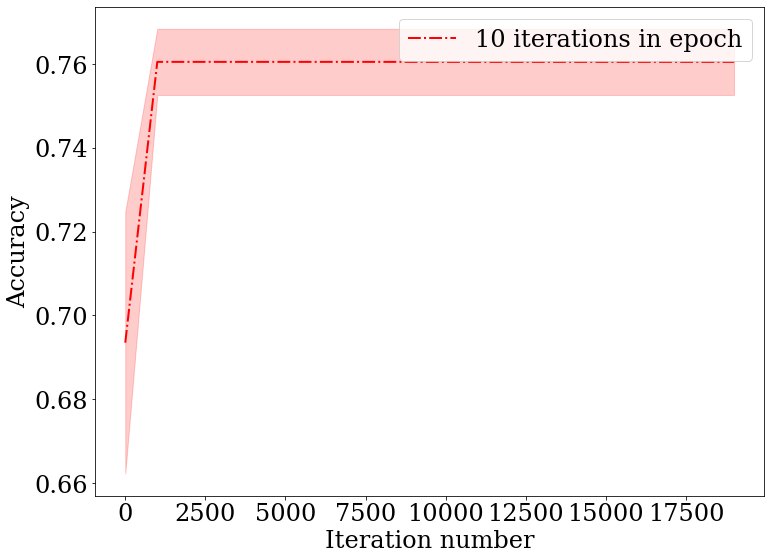

In [8]:
plot_data_params(data_10, 'accuracy', '10 iterations in epoch', 'red', '.')
plot_data_params(data_100, 'accuracy', '100 iterations in epoch', 'blue', '3')
plot_data_params(data_500, 'accuracy', '500 iterations in epoch', 'green', '^')
plot_data_params(data_1000, 'accuracy', '1000 iterations in epoch', 'black', '+')
plot_data_params(data_2000, 'accuracy', '2000 iterations in epoch', 'orange', 'x')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
plt.savefig('../figs/synthetic_exp3_linear_epoch_size.pdf')
plt.show()

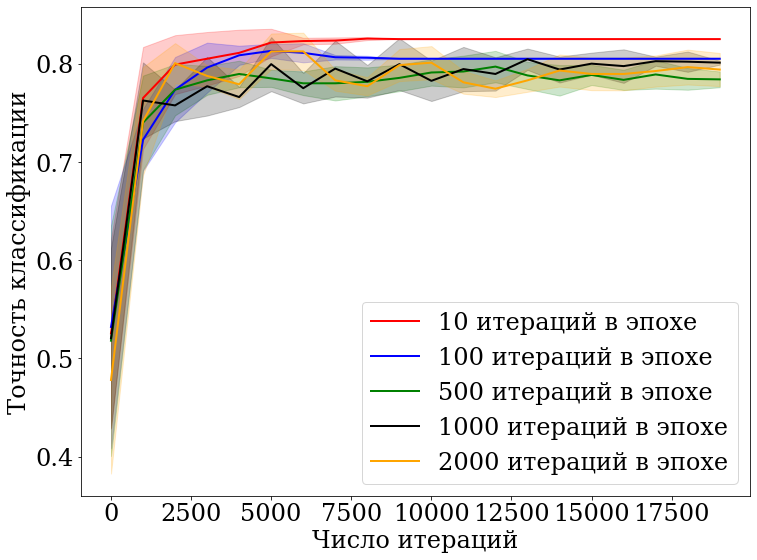

In [16]:
plot_data_params(data_10, 'accuracy', '10 iterations in epoch', 'red', '')
plot_data_params(data_100, 'accuracy', '100 iterations in epoch', 'blue', '')
plot_data_params(data_500, 'accuracy', '500 iterations in epoch', 'green', '')
plot_data_params(data_1000, 'accuracy', '1000 iterations in epoch', 'black', '')
plot_data_params(data_2000, 'accuracy', '2000 iterations in epoch', 'orange', '')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
plt.savefig('../figs/synthetic_exp3_linear_epoch_size_color.pdf')
plt.show()

In [17]:
data_2 = open_data_json("../log/synthetic_exp3_splines_esize_10_period_2.jsonl")
data_3 = open_data_json("../log/synthetic_exp3_splines_esize_10_period_3.jsonl")
data_5 = open_data_json("../log/synthetic_exp3_splines_esize_10_period_5.jsonl")
data_10 = open_data_json("../log/synthetic_exp3_splines_esize_10_period_10.jsonl")

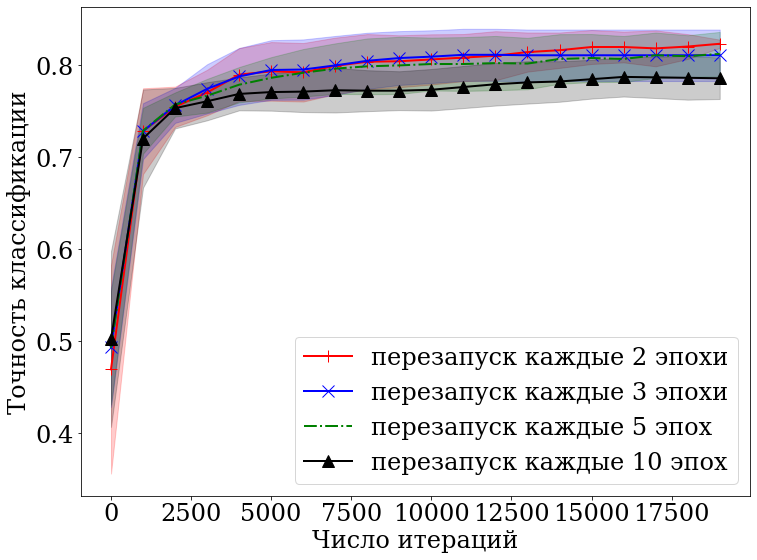

In [19]:
plot_data_params(data_2, 'accuracy', 'rerun every 2 epochs', 'red', '+')
plot_data_params(data_3, 'accuracy', 'rerun every 3 epochs', 'blue', 'x')
plot_data_params(data_5, 'accuracy', 'rerun every 5 epochs', 'green', '.')
plot_data_params(data_10, 'accuracy', 'rerun every 10 epochs', 'black', '^')
plt.legend()
plt.xlabel('iterations in epoch')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных train_splines_every_epoch')
plt.savefig('../figs/synthetic_exp3_linear_train_splines_every_epoch.pdf')
plt.show()

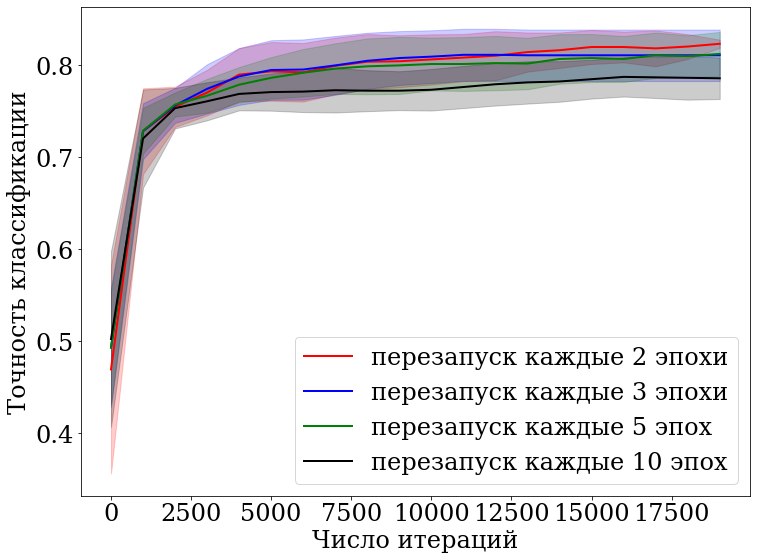

In [18]:
plot_data_params(data_2, 'accuracy', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_3, 'accuracy', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_5, 'accuracy', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_10, 'accuracy', 'rerun every 10 epochs', 'black', '')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных train_splines_every_epoch')
plt.savefig('../figs/synthetic_exp3_linear_train_splines_every_epoch_color.pdf')
plt.show()

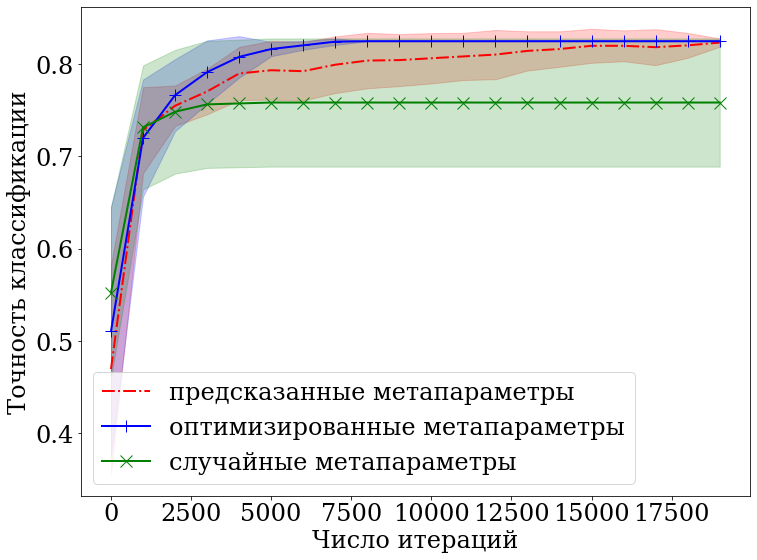

In [21]:
plot_data_params(data_s, 'accuracy', 'predicted meta-parameters', 'red', '.')
plot_data_params(data_h, 'accuracy', 'meta-parameter optimization', 'blue', '+')
plot_data_params(data_dr, 'accuracy', 'random meta-parameters', 'green', 'x')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации')
plt.savefig('../figs/synthetic_exp3_acc_iter.pdf')
plt.show()

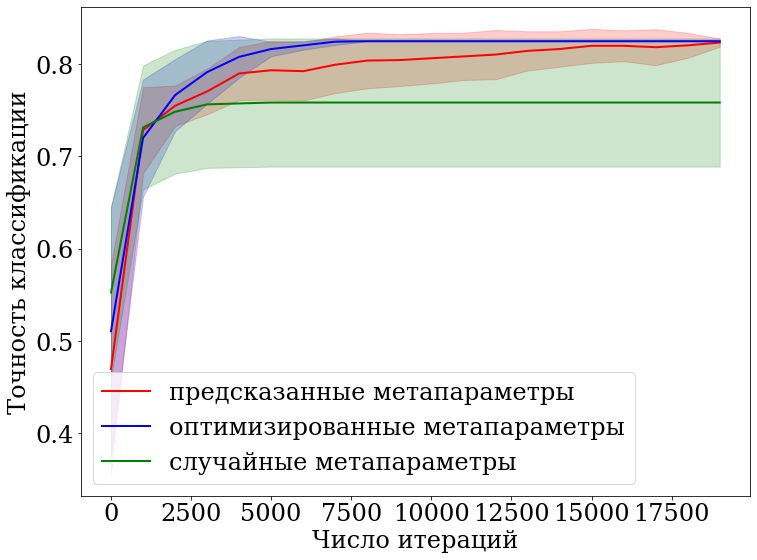

In [20]:
plot_data_params(data_s, 'accuracy', 'predicted meta-parameters', 'red', '')
plot_data_params(data_h, 'accuracy', 'meta-parameter optimization', 'blue', '')
plot_data_params(data_dr, 'accuracy', 'random meta-parameters', 'green', '')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации')
plt.savefig('../figs/synthetic_exp3_acc_iter_color.pdf')
plt.show()

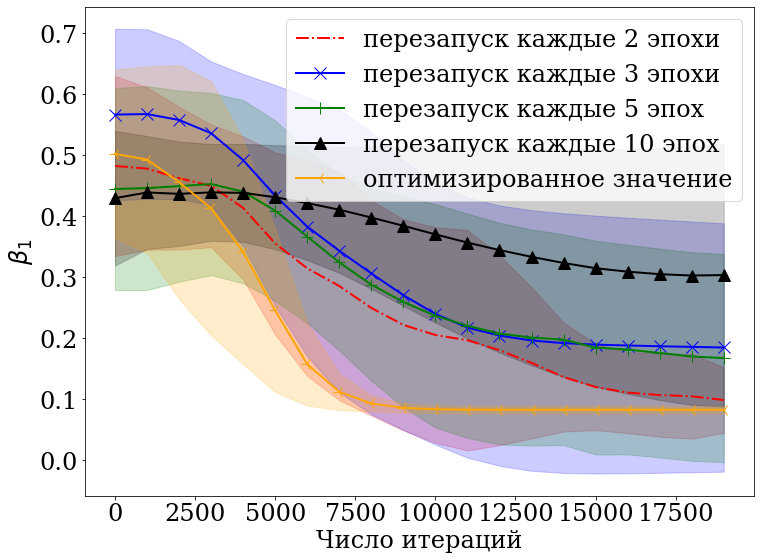

In [28]:
plot_data_params(data_spline2, 'lambda1', 'rerun every 2 epochs', 'red', '.')
plot_data_params(data_spline3, 'lambda1', 'rerun every 3 epochs', 'blue', 'x')
plot_data_params(data_spline5, 'lambda1', 'rerun every 5 epochs', 'green', '+')
plot_data_params(data_spline10, 'lambda1', 'rerun every 10 epochs', 'black', '^')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_1$')
# plt.title(r'График зависимости значения $\lambda_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda1_iter.pdf')
plt.show()

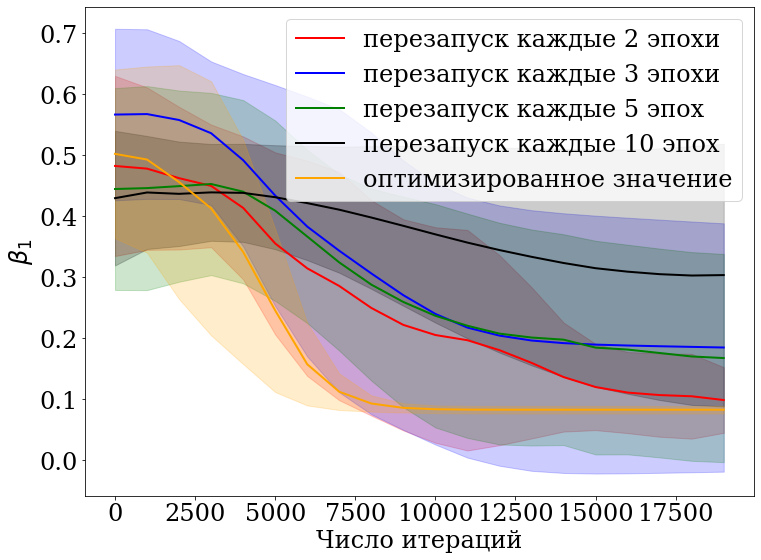

In [29]:
plot_data_params(data_spline2, 'lambda1', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_spline3, 'lambda1', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_spline5, 'lambda1', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_spline10, 'lambda1', 'rerun every 10 epochs', 'black', '')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_1$')
# plt.title(r'График зависимости значения $\lambda_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda1_iter_color.pdf')
plt.show()

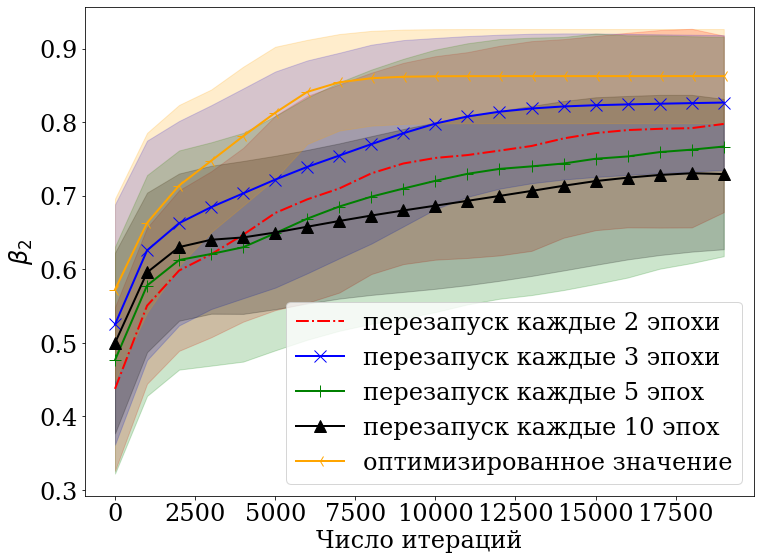

In [30]:
plot_data_params(data_spline2, 'lambda2', 'rerun every 2 epochs', 'red', '.')
plot_data_params(data_spline3, 'lambda2', 'rerun every 3 epochs', 'blue', 'x')
plot_data_params(data_spline5, 'lambda2', 'rerun every 5 epochs', 'green', '+')
plot_data_params(data_spline10, 'lambda2','rerun every 10 epochs', 'black', '^')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_2$')
# plt.title(r'График зависимости значения $\lambda_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda2_iter.pdf')
plt.show()

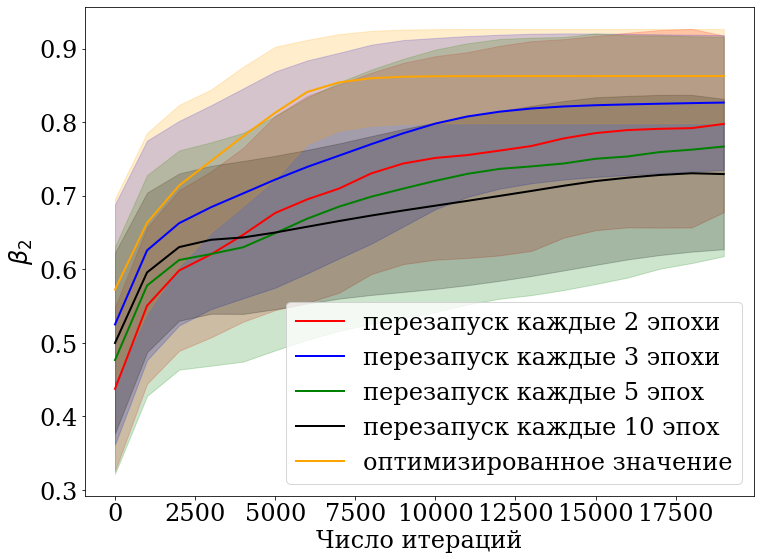

In [31]:
plot_data_params(data_spline2, 'lambda2', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_spline3, 'lambda2', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_spline5, 'lambda2', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_spline10, 'lambda2', 'rerun every 10 epochs', 'black', '')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_2$')
# plt.title(r'График зависимости значения $\lambda_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda2_iter_color.pdf')
plt.show()

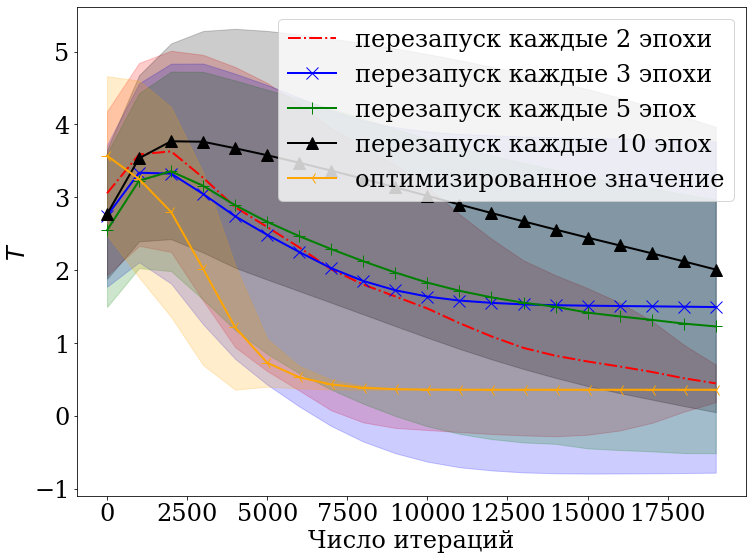

In [32]:
plot_data_params(data_spline2, 'temp', 'rerun every 2 epochs', 'red', '.')
plot_data_params(data_spline3, 'temp', 'rerun every 3 epochs', 'blue', 'x')
plot_data_params(data_spline5, 'temp', 'rerun every 5 epochs', 'green', '+')
plot_data_params(data_spline10, 'temp', 'rerun every 10 epochs', 'black', '^')

plt.xlabel('Iteration number')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_temp_iter.pdf')
plt.show()

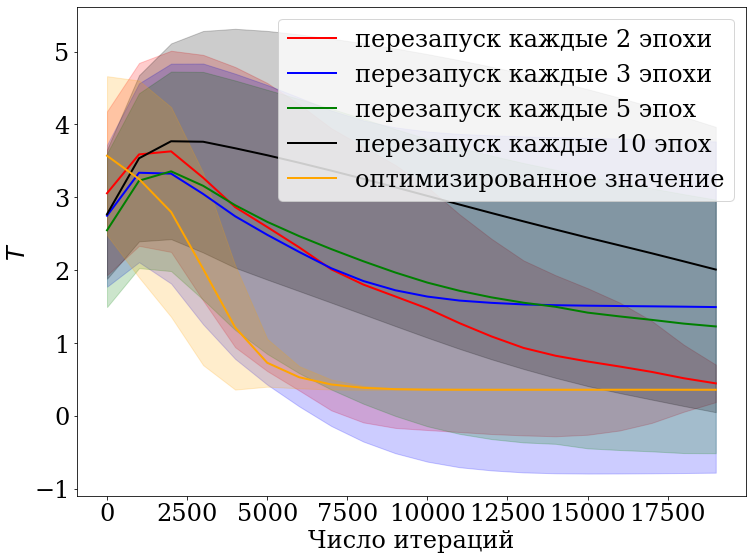

In [33]:
plot_data_params(data_spline2, 'temp', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_spline3, 'temp', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_spline5, 'temp', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_spline10, 'temp', 'rerun every 10 epochs', 'black', '')

plt.xlabel('Iteration number')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_temp_iter_color.pdf')
plt.show()